In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
'''
NOTE: These parameters are ajusted for a very fast training stage
 if you have a cuda-enabled GPU and free time you can try to tune 
 them to optain an optimal performance
'''

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 15 # timesteps
n_hidden = 150 # hidden layer num of features
n_classes = 28 # MNIST total classes (0-9 digits)


training_iters = 1000

batch_size = 150

In [3]:
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
istate = tf.placeholder("float", [None, 2*n_hidden]) #state & cell => 2x n_hidden
y_ = tf.placeholder("float", [None, n_classes])

w_fc1 = tf.Variable(tf.random_normal([n_input, n_hidden])) # Hidden layer weights
w_fc2 = tf.Variable(tf.random_normal([n_hidden, n_classes]))

b_fc1 = tf.Variable(tf.random_normal([n_hidden]))
b_fc2 = tf.Variable(tf.random_normal([n_classes]))

# input shape: (batch_size, n_steps, n_input)
x_internal = tf.transpose(x, [1, 0, 2])
x_internal = tf.reshape(x_internal, [-1, n_input]) # (n_steps*batch_size, n_input)

h_fc1 = tf.matmul(x_internal, w_fc1) + b_fc1
lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

h_fc1 = tf.split(0, n_steps, h_fc1) # n_steps * (batch_size, n_hidden)
outputs, states = rnn.rnn(lstm_cell, h_fc1, initial_state=istate)

y = tf.nn.sigmoid(tf.matmul(outputs[-1], w_fc2) + b_fc2)


mse = tf.reduce_mean(tf.square(y_-y)) # MSE loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(mse)

In [4]:
''' 
 This function creates several training sequences from each
 MNIST sample image, each training sequence consists of #n_steps samples
 with 28 features.
'''

def sequencesFromTrainingData(data, nSteps):
    
    X = []
    Y = []
    
    for sample in data:
        sample = sample.reshape((28,28))
        for i in range(27-nSteps):
            X.append(sample[i:i+nSteps,:])
            Y.append(sample[i+nSteps][:])
    return np.asarray(X), np.asarray(Y)
        


In [5]:
# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
sess = tf.Session()
sess.run(init)
step = 1

for i in range(training_iters):
    batch_xs,_ = mnist.train.next_batch(batch_size)
    batch_xs, batch_ys = sequencesFromTrainingData(batch_xs, n_steps)
    sess.run(optimizer, feed_dict={x: batch_xs, y_: batch_ys,
                                   istate: np.zeros((batch_size*(27-n_steps), 2*n_hidden))})
    if step % 10 == 0:
        loss = sess.run(mse, feed_dict={x: batch_xs, y_: batch_ys,
                                         istate: np.zeros((batch_size*(27-n_steps), 2*n_hidden))})
        print "Iter " + str(step) + ", Minibatch Loss= " + "{:.6f}".format(loss)
    step += 1
    
print "Optimization Finished!" 

Iter 10, Minibatch Loss= 0.066640
Iter 20, Minibatch Loss= 0.057214
Iter 30, Minibatch Loss= 0.052962
Iter 40, Minibatch Loss= 0.037202
Iter 50, Minibatch Loss= 0.038240
Iter 60, Minibatch Loss= 0.034530
Iter 70, Minibatch Loss= 0.030626
Iter 80, Minibatch Loss= 0.031049
Iter 90, Minibatch Loss= 0.025884
Iter 100, Minibatch Loss= 0.037439
Iter 110, Minibatch Loss= 0.031968
Iter 120, Minibatch Loss= 0.027933
Iter 130, Minibatch Loss= 0.028688
Iter 140, Minibatch Loss= 0.024916
Iter 150, Minibatch Loss= 0.030057
Iter 160, Minibatch Loss= 0.028029
Iter 170, Minibatch Loss= 0.027199
Iter 180, Minibatch Loss= 0.027356
Iter 190, Minibatch Loss= 0.023549
Iter 200, Minibatch Loss= 0.021242
Iter 210, Minibatch Loss= 0.021889
Iter 220, Minibatch Loss= 0.020250
Iter 230, Minibatch Loss= 0.020237
Iter 240, Minibatch Loss= 0.020930
Iter 250, Minibatch Loss= 0.021620
Iter 260, Minibatch Loss= 0.020093
Iter 270, Minibatch Loss= 0.019723
Iter 280, Minibatch Loss= 0.018861
Iter 290, Minibatch Loss= 0.0

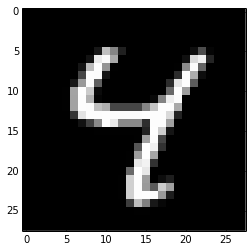

(28, 28)


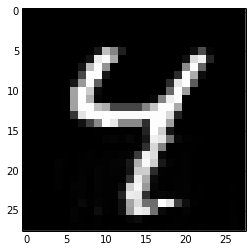

In [12]:
'''
Here the trained network is used to reconstruct a digit.
It is not exactly fair as the network always observes the original 
image to predict the next row, so the reconstruction is almost perfect
'''

sample = mnist.test.next_batch(1)[0]
seq,_ = sequencesFromTrainingData(sample,n_steps)

p = sess.run(y, feed_dict={x: seq,
                          istate: np.zeros((seq.shape[0], 2*n_hidden))} )

sample = sample[0].reshape(28,28)

plt.imshow(sample, interpolation="none", cmap="gray")
plt.show()



sample[16:, :] = p.reshape(-1,28) 
print sample.shape

plt.imshow(sample, interpolation="none", cmap="gray")

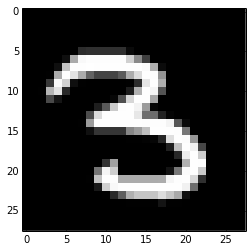

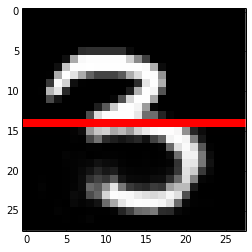

In [19]:
'''
Here the trained network is used to reconstruct a digit in a more difficult way.
The network observes only the #n_steps first rows of the original image 
and then it tries to reconstruct the rest

Note that the window of #n_steps observerd rows moves down as the digit is reconstructed so
each predicted row is considered as part of the input for the next prediction. 
'''

import matplotlib as mpl 

sample = mnist.train.next_batch(1)[0][0].reshape((28,28))
plt.imshow(sample, interpolation="none", cmap="gray")
plt.show()



line = np.zeros((28,28))
line[n_steps, :] = 1
line = np.ma.masked_where(y == 0, y)



for i in range(12):
    
    p = sess.run(y, feed_dict={x: [sample[i:i+n_steps,:]],
                          istate: np.zeros((1, 2*n_hidden))} )
    sample[i+n_steps] = p

sampleRGB = np.zeros((28,28,3))   

sampleRGB[:,:,0] = sample
sampleRGB[:,:,1] = sample
sampleRGB[:,:,2] = sample

sampleRGB[14,:,:] = 0
sampleRGB[14,:,0] = 1
    
# The red line divides the observed part from the reconstructed part.
# Note that sometimes the net can not identify the digit correctly 
# but it draws a consistent digit anyway    
    
plt.imshow(sampleRGB, interpolation="none")
